### Парсинг данных и создание датафрейма

In [67]:
def procents(d):
    l = len(d)
    res = []
    for name in set(d['name']):
        count = len(d[d['name'] == name])
        res.append((name, count, count/l*100))
    return pd.DataFrame(res, columns=['name', 'count', 'percent'])

In [68]:
def dose_weights(d):
    l = len(d)
    res = []
    total_dose = sum(d['dE'])
    for name in set(d['name']):
        particle_filt = d[d['name'] == name]
        dose = sum(particle_filt['dE'])
        res.append((name, dose, dose/total_dose*100))
    return pd.DataFrame(res, columns=['name', 'dose', 'dose_percent'])

In [69]:
def get_z_dose_bins(d, bins=100):
    borders = np.linspace(-20, 20, bins)
    bins = []
    for i in range(len(borders[:-1])):
        dd = d[d['z'] > borders[i]]
        bin_data = dd[dd['z'] < borders[i+1]]
        bins.append(sum(bin_data['dE']))
    return np.array(borders[:-1])+20, np.array(bins)

In [70]:
def get_energy_count_bins(d, bins=100):
    n, e = np.histogram(d['energy'], bins)
    return e[:-1], n

In [71]:
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [72]:
runN = "*" # If take all runs set runN = "*"
paths = glob.glob(f"build/Run{runN}_nt_ParticleData_t*.csv") #accel_data_secondary
assert len(paths) == 20

In [73]:
with open(paths[0], 'r') as f:
    print(f"Headers from file: {paths[0]}")

    hlines = []
    while True:
        line = f.readline()
        if len(line) == 0 or line[0] != '#':
            break
        hlines.append(line)
    title = hlines[1].replace('#title ', '')[:-1]
    sep = chr(int(hlines[2].replace('#separator ', '')[:-1]))
    vsc_sep = chr(int(hlines[3].replace('#vector_separator ', '')[:-1]))
    columns = [' '.join(l.split(' ')[2:])[:-1] for l in hlines[4:]]
    meta_len = len(hlines)
    # print(f'Metarows: {meta_len}\nColumns: {columns}')

Headers from file: build/Run0_nt_ParticleData_t8.csv


In [74]:
pnames = {'annihil':'Аннигиляция','compt':'Комптон-эффект','conv':'Рождение пар',
          'eBrem':'Тормозное излучение','eIoni':'Ионизационные потери','hadElastic':'?',
          'phot':'Фотоэффект','photonNuclear':'?'}

In [75]:
data = pd.DataFrame()
for path in paths[:10]:
    item = pd.read_csv(path, skiprows=meta_len, names=columns)
    data = pd.concat([data, item], ignore_index=True)

In [76]:
len(data)

10925928

In [77]:
data

,name,creator_process,energy,z,dE
0,gamma,user,1.158420,-20.000000,0.000014
1,gamma,user,0.534114,-2.683950,0.000537
2,gamma,user,0.534114,0.297007,0.000000
3,e-,compt,0.593445,0.297007,0.030323
4,e-,compt,0.478106,0.315491,0.115339
...,...,...,...,...,...
10925923,e-,eIoni,0.076909,7.288480,0.029212
10925924,e-,eIoni,0.052263,7.284870,0.024646
10925925,e-,eIoni,0.035371,7.282570,0.016892
10925926,e-,eIoni,0.014260,7.282640,0.021111


## "Первичные" ускорительные частицы

In [78]:
primary = data[data['creator_process'] == 'user']
len(primary)

2191980

In [79]:
procents(primary)

,name,count,percent
0,e+,35446,1.617077
1,neutron,46401,2.116853
2,e-,917606,41.861970
3,gamma,1192527,54.404100


In [80]:
print('Суммарная доза от первичных частиц:', sum(dose_weights(primary)['dose']))
dose_weights(primary)

Суммарная доза от первичных частиц: 37244.398456309566


,name,dose,dose_percent
0,e+,2180.715624,5.855151
1,neutron,194.117591,0.521199
2,e-,34741.042098,93.278569
3,gamma,128.523143,0.345080


## Вторичные частицы в фантоме

In [81]:
secondary = data[data['creator_process'] != 'user']
len(secondary)

8733948

In [82]:
print('Суммарная доза от вторичных частиц:', sum(dose_weights(secondary)['dose']))
dose_weights(secondary)

Суммарная доза от вторичных частиц: 425132.0795659667


,name,dose,dose_percent
0,O17,0.000041,9.735233e-09
1,O16,39.639670,9.324083e-03
2,O15,0.077820,1.830481e-05
3,O18,0.158966,3.739217e-05
4,e+,18787.019613,4.419102e+00
5,deuteron,0.203293,4.781876e-05
6,N15,0.929196,2.185664e-04
7,C12,15.069317,3.544620e-03
8,proton,981.400105,2.308459e-01
9,alpha,44.402987,1.044452e-02


## Доза от глубины

**Доза от первичных и вторичных частиц**

In [83]:
borders1, bins1 = get_z_dose_bins(data)
borders2, bins2 = get_z_dose_bins(primary)
borders3, bins3 = get_z_dose_bins(secondary)

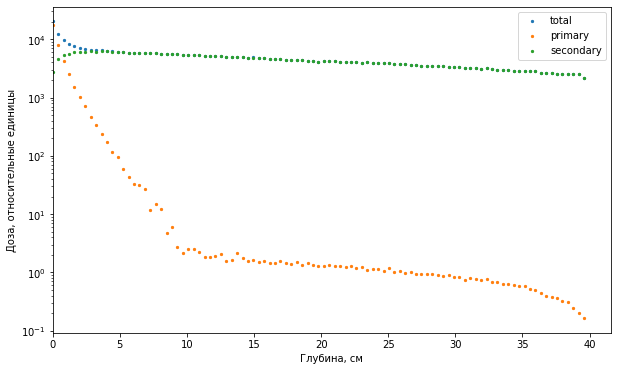

In [84]:
plt.scatter(borders1, bins1, s=5, label='total')
plt.scatter(borders2, bins2, s=5, label='primary')
plt.scatter(borders3, bins3, s=5, label='secondary')
plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

**Доза от первичных частиц**

In [85]:
borders1, bins1 = get_z_dose_bins(primary[primary['name'] == 'e-'])
borders2, bins2 = get_z_dose_bins(primary[primary['name'] == 'gamma'])

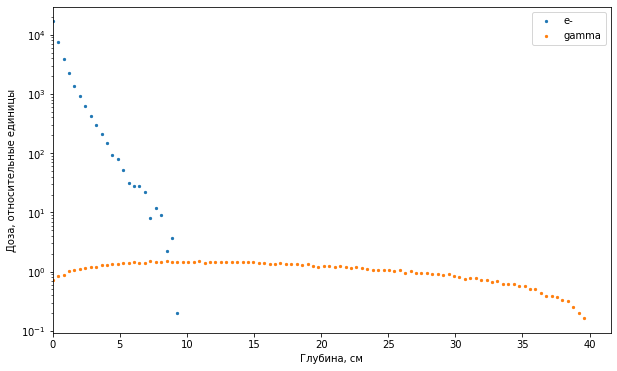

In [86]:
plt.scatter(borders1, bins1, s=5, label='e-')
plt.scatter(borders2, bins2, s=5, label='gamma')
plt.xlim([0, plt.xlim()[1]])
# plt.ylim([0, plt.ylim()[1]])
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

**Доза от вторичных частиц**

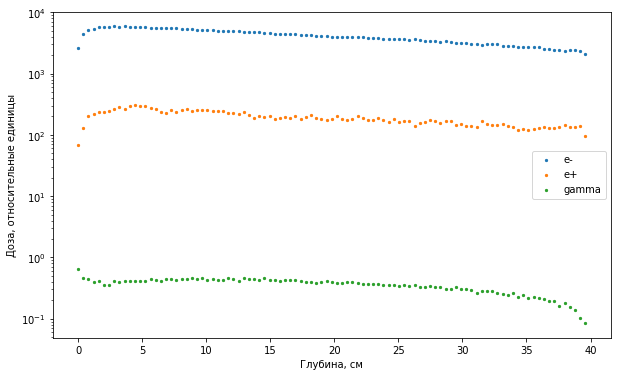

In [87]:
for name in ['e-','e+', 'gamma']:
    borders, bins = get_z_dose_bins(secondary[secondary['name'] == name])
    plt.scatter(borders, bins, s=5, label=name)
plt.yscale('log')
plt.ylabel('Доза, относительные единицы')
plt.xlabel('Глубина, см')
plt.legend()
plt.show()

## Распределение по энергиям

**Энергия по вторичным частицам**

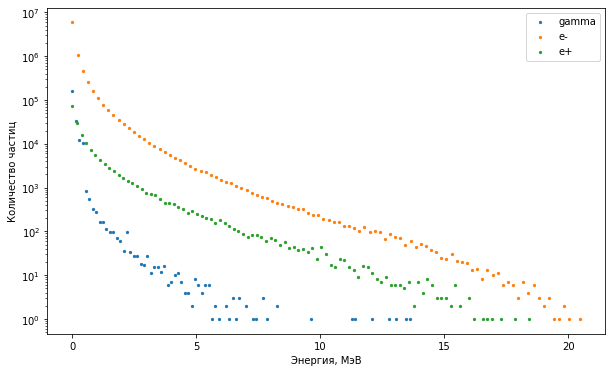

In [88]:
for pname in ['gamma', 'e-', 'e+']:
    names_particle = secondary[secondary['name'] == pname]
    energys, counts = get_energy_count_bins(names_particle)
    plt.scatter(energys, counts, s=5, label=pname)

plt.legend()
# plt.ylim([10, 10**8])
plt.yscale('log')
plt.ylabel('Количество частиц')
plt.xlabel('Энергия, МэВ')
plt.show()

**Энергия вторичной частицы по процессу рождения**

In [89]:
def energy_by_process(paticles):
    for process in pnames.keys():
        names_process = paticles[paticles['creator_process'] == process]
        if len(names_process) == 0:
            continue
        energys, counts = get_energy_count_bins(names_process)
        plt.scatter(energys, counts, s=5, label=pnames[process])

    plt.legend()
    # plt.ylim([10, 10**8])
    plt.yscale('log')
    plt.ylabel('Количество частиц')
    plt.xlabel('Энергия, МэВ')
    plt.show()

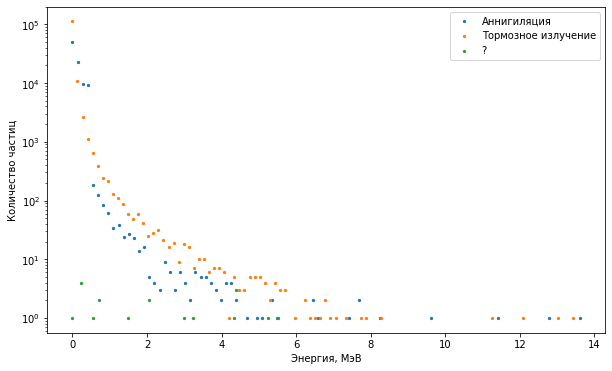

In [90]:
paticles = secondary[secondary['name'] == 'gamma']
energy_by_process(paticles)

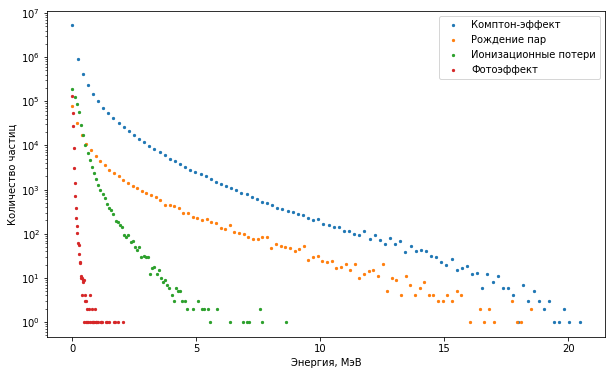

In [92]:
paticles = secondary[secondary['name'] == 'e-']
energy_by_process(paticles)

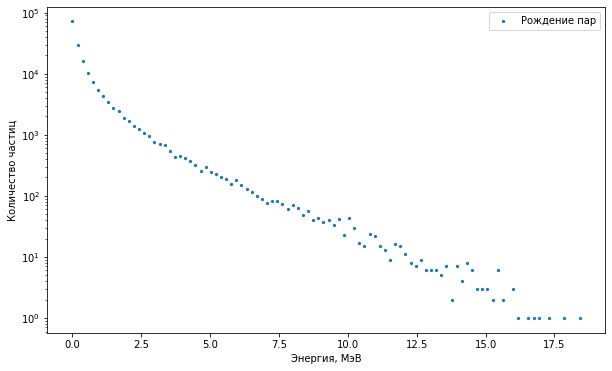

In [93]:
paticles = secondary[secondary['name'] == 'e+']
energy_by_process(paticles)